In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
from datasets import load_dataset
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Clasificación de Sentimientos**

Utilizando Python y la librería NLTK y con ayuda del siguiente código cargue una
muestra del 30% del dataset de comentarios de usuarios (Amazon reviews). Donde el campo label indica con 1 las reseñas positivas y 0 las negativas

In [ ]:
# Cargar el dataset de IMDb
dataset = load_dataset("imdb")
# Convertir a DataFrame para una fácil manipulación
train_df_total = pd.DataFrame(dataset['train'])
test_df_total = pd.DataFrame(dataset['test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uso 15% porque no me da la RAM

In [ ]:
train_df = train_df_total.sample(frac=0.15, random_state=42)
test_df = test_df_total.sample(frac=0.15, random_state=42)

In [ ]:
train_df.head()

,text,label
6868,"Dumb is as dumb does, in this thoroughly unint...",0
24016,I dug out from my garage some old musicals and...,1
9668,After watching this movie I was honestly disap...,0
13640,This movie was nominated for best picture but ...,1
14018,Just like Al Gore shook us up with his painful...,1


## 1. Realice las siguientes tareas de preprocesamiento de texto:
*   Tokenización del texto.
*   Eliminación de stopwords.
*   Aplicación de Stemming o Lematización.


Cargo las stop words en inglés y el lematizador.

Creo una función que haga todo lo que pide.

In [ ]:
stopwords_en = stopwords.words('english')
# Crear un objeto lematizador
lemmatizer = WordNetLemmatizer()

def normalizar_texto(texto):
    # Tokenización:
    tokens = nltk.word_tokenize(str(texto))
    # Eliminar stop words:
    tokens = [token for token in tokens if token not in stopwords_en]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lematizar cada palabra
    return ' '.join(lemmatized_tokens) # Vuelve a unir las palabras con un espacio de por medio

A cada línea de los dfs le aplico la normalización del texto y creo la nueva columna llamada texto limpio

In [ ]:
train_df["texto_limpio"] = train_df["text"].apply(normalizar_texto)
test_df["texto_limpio"] = test_df["text"].apply(normalizar_texto)

In [ ]:
train_df.head()

,text,label,texto_limpio
6868,"Dumb is as dumb does, in this thoroughly unint...",0,"Dumb dumb , thoroughly uninteresting , suppose..."
24016,I dug out from my garage some old musicals and...,1,I dug garage old musical another one favorite ...
9668,After watching this movie I was honestly disap...,0,After watching movie I honestly disappointed -...
13640,This movie was nominated for best picture but ...,1,This movie nominated best picture lost Casabla...
14018,Just like Al Gore shook us up with his painful...,1,Just like Al Gore shook u painfully honest cle...


## 2. Utilice técnicas de representación de texto como Bag-of-Words o TF-IDF para transformar los comentarios en vectores.

Uno ambos datasets para que cuando los vectorice ambos tengan las mismas columnas. Si no hiciera esto y en el train dataset hay una palabra que luego no está en el test, no me coincidirían las columnas y esto sería un problema a la hora de usar el modelo.

In [ ]:
df = pd.concat([train_df, test_df], ignore_index=True)

Vectorizo tanto el train como el test

In [ ]:
vectorizer = TfidfVectorizer(max_df = 0.8, analyzer='word', token_pattern=r'\w+',
                             use_idf=True, smooth_idf=True, sublinear_tf=True,
                             stop_words='english')

X = vectorizer.fit_transform(df['texto_limpio'])

# Convertir la matriz dispersa en un DataFrame de pandas
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
X_df.head()

,0,00,000,001,007,0079,0080,0083,0093638,00o,...,è,élan,émigré,était,état,étienne,êxtase,ïts,úber,þór
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3 y 4. Entrene un modelo de clasificación (por ejemplo, una Regresión Logística o un Naive Bayes) para predecir la polaridad del sentimiento (positivo o negativo) y evalúe el modelo utilizando métricas adecuadas como Accuracy, precisión, recall y F1-score. Discuta los resultados obtenidos.

In [ ]:
X_df

,0,00,000,001,007,0079,0080,0083,0093638,00o,...,è,élan,émigré,était,état,étienne,êxtase,ïts,úber,þór
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Los y van a ser las labels

In [ ]:
# Las etiquetas también deben ser separadas
y_train = train_df['label']  # Ajustar 'label' al nombre real de la columna de etiquetas en tu DataFrame
y_test = test_df['label']    # Ajustar 'label' al nombre real de la columna de etiquetas en tu DataFrame

In [ ]:
len(y_train)

3750

In [ ]:
len(y_test)

3750

Como los primeros 3750 son train y los últimos 3750 son test los separo así, probé de otras maneras que me parecen mejor pero no me daba la RAM.

In [ ]:
X_train = X_df.head(3750)
X_test = X_df.tail(3750)

**Regresión logística y Naive Bayes**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Entrenar y evaluar el modelo de Regresión Logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Entrenar y evaluar el modelo de Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calcular las métricas para Regresión Logística
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg, average='weighted')
recall_logreg = recall_score(y_test, y_pred_logreg, average='weighted')
f1_logreg = f1_score(y_test, y_pred_logreg, average='weighted')

print("Regresión Logística - Accuracy:", accuracy_logreg)
print("Regresión Logística - Precision:", precision_logreg)
print("Regresión Logística - Recall:", recall_logreg)
print("Regresión Logística - F1 Score:", f1_logreg)
print("Regresión Logística - Classification Report:\n", classification_report(y_test, y_pred_logreg))

# Calcular las métricas para Naive Bayes
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

print("Naive Bayes - Accuracy:", accuracy_nb)
print("Naive Bayes - Precision:", precision_nb)
print("Naive Bayes - Recall:", recall_nb)
print("Naive Bayes - F1 Score:", f1_nb)
print("Naive Bayes - Classification Report:\n", classification_report(y_test, y_pred_nb))


Regresión Logística - Accuracy: 0.8448
Regresión Logística - Precision: 0.8455107377049181
Regresión Logística - Recall: 0.8448
Regresión Logística - F1 Score: 0.8447896697822186
Regresión Logística - Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1908
           1       0.83      0.86      0.85      1842

    accuracy                           0.84      3750
   macro avg       0.85      0.85      0.84      3750
weighted avg       0.85      0.84      0.84      3750

Naive Bayes - Accuracy: 0.8037333333333333
Naive Bayes - Precision: 0.8199015036701183
Naive Bayes - Recall: 0.8037333333333333
Naive Bayes - F1 Score: 0.800703636728418
Naive Bayes - Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83      1908
           1       0.89      0.68      0.77      1842

    accuracy                           0.80      3750
   macro avg       0.8

La Regresión Logística (84.48%) supera a Naive Bayes (80.37%) en el accuracy. Esto significa que la Regresión Logística tiene una tasa de predicciones correctas mayor que Naive Bayes en general.

También tiene una precisión ligeramente mejor (84.55%) que Naive Bayes (81.99%). Esto indica que el modelo de Regresión Logística es un poco mejor en evitar falsos positivos (reseñas clasificadas como positivas que eran negativas). Necesitaría un mayor contexto para saber qué tan importante es esta métrica porque dependiendo del caso voy a querer minimizar los falsos positivos o los falsos negativos (ambos son malos pero por lo general uno es peor que el otro).

La Regresión Logística y Naive Bayes tienen recall similares pero difieren en las clases. Naive Bayes tiene un recall significativamente más alto para la Clase 0 (92% - sentimiento negativo) en comparación con la Clase 1 (68% - sentimiento positivo). La Regresión Logística tiene recall más equilibrado para ambas clases (83% para la Clase 0 y 86% para la Clase 1).


La Regresión Logística (84.48%) también supera a Naive Bayes (80.07%) en la puntuación F1 global . La puntuación F1 toma en cuenta tanto la precisión como el recall, y un mayor valor indica un mejor rendimiento en general.

Dado que la Regresión Logística tiene mejores métricas en general y un mejor equilibrio entre las clases, recomendaría utilizar la Regresión Logística para este problema de clasificación de sentimientos.

## 5. Explique que otras técnicas más avanzadas que vimos en clase podríamos aplicar para mejorar los resultados.

Hay varias cosas que se podrían probar para mejorar los resultados:
*   Utilizar todo el dataset de train para poder pasarle más datos al modelo para que se ajuste.
*   Word Embeddings: Usar representaciones densas de palabras como Word2Vec, GloVe o embeddings aprendidos por modelos para capturar mejor las relaciones semánticas entre las palabras en comparación con TF-IDF.
*   Ajustar los hiperparámetros de los modelos con un Grid search que busque la mejor combinación de hiperparámetros.
*   Modelos de ensable: Combinar varios modelos para mejorar la precisión y la robustez del sistema. Los métodos de ensamble como Random Forests, Gradient Boosting, o Stacking pueden proporcionar mejores resultados que un solo modelo.

# **Algoritmos genéticos**

## a. Utilizando el código fuente que vimos en clase, indique qué cambios podría hacer para mejorar la función de aptitud. Escriba el/los cambios propuestos y justifique por qué ese cambio mejora la función de aptitud.

Una función de aptitud mide cuánto me acerco a un objetivo. El problema es que no está teniendo en cuanta lo siguiente: cuando yo tengo genotipos muy largos o grandes es muy fácil acertar cierta parte por cuestiones probabilísticas. Lo difícil no es acertar la primer parte sino la parte final. En este caso, la función de aptitud lineal puede no ser suficiente para reflejar las mejoras significativas en la proximidad al objetivo en las partes más difíciles del genotipo.

La solución está en transformar la función de aptitud en una funcion exponencial. Se va a lograr en menos generaciones porque los saltos son mayores que en una lineal. Esto significa que los individuos que están más cerca del objetivo reciben una recompensa mucho mayor en términos de aptitud en comparación con aquellos que están más lejos, incentivando así mejoras significativas en el genotipo.


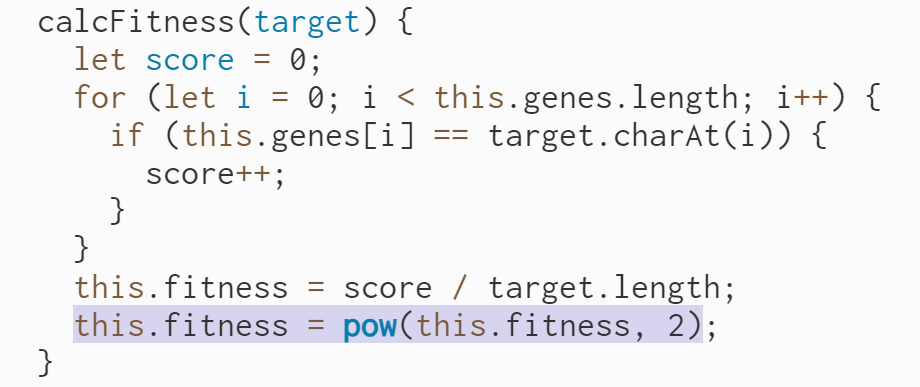

Agregando esta linea de código (si ponemos un número mayor en vez de un 2, menos va a aumentar al principio y más va a premiar sobre la recta final) podemos hacer que llegue al objetivo en menos tiempo y hacer más eficiente el proceso.

Existe la posibilidad que de la primera generación (más que nada si son pocos elementos en la población) ninguno pase porque todos tengan un fitness value de 0. En este caso, cuando intentemos seleccionar a los padres podemos entrar en un bucle infinito en el que ningún padre logre ser aceptado.

¿Cómo salir de este problema? Artificialmente vamos a calcular la función de aptitud así:


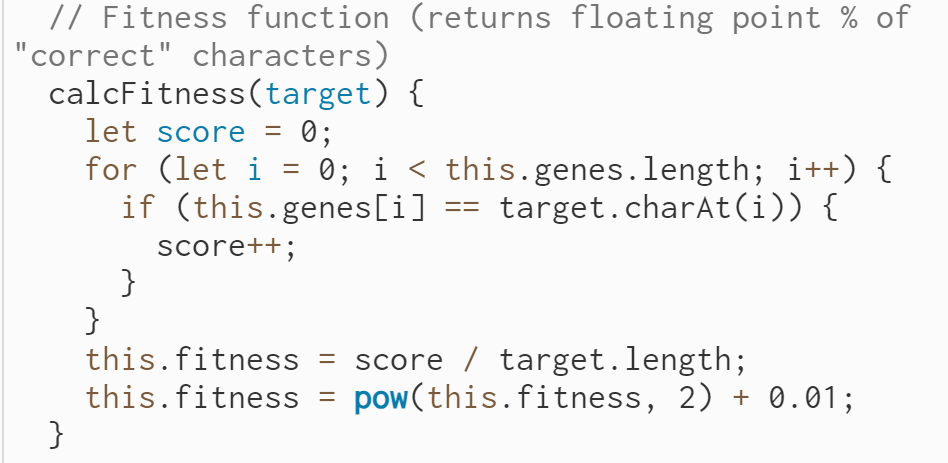

Le sumamos 0.01 para ayudarlo salir del bucle. Por más que 0.01 represente un pocos individuos dentro del mating pool o que tenga poca probabilidad de ser aceptado en métodos como accept/reject, eventualmente van a tener algo de participación y con la mutación podremos hacer que mejoren.

## b. Imagine distintos problemas resueltos con AG, ¿qué partes del código debería modificar entre ellos?. Copie y pegue las secciones de código que tiene que cambiar y justifique dicha elección.

Dependiendo del caso que estemos trabajando vamos a tener que modificar unas cosas u otras pero estas son las que podemos cambiar:



Estos son los hiperparámetros que podemos variar:
*   **Elementos de la población**: la cantidad de individuos en la población pueden necesitar ajustes dependiendo del problema para asegurar diversidad genética.
*   **Mutation rate**: Diferentes problemas pueden requerir diferentes tasas de mutación dependiendo del tamaño de la población para evitar que no converjan.
*   **Método de selección de padres**: Distintos problemas pueden beneficiarse de diferentes métodos de selección (por ejemplo, matting pool, método del dardo, accept/reject).
*   **Cross over**

*   **Genotipo**: la representación de los individuos en la población. No es lo mismo representar una imagen, pasos o un código.
*   **Función de aptitud** (qué mido para determinar la performance): Cada problema tiene diferentes criterios de evaluación. La función de aptitud debe ser diseñada específicamente para el objetivo del problema, de modo que guíe la evolución hacia soluciones efectivas.




Todo depende de qué problema partamos y qué problema queramos resolver pero las cosas clave a cambiar son el genotipo y la función de aptitud. Otros componentes como los nombrados anteriormente también juegan un papel importante en la eficacia del algoritmo y pueden requerir ajustes para abordar las particularidades de diferentes problemas.

Partes del código que hay que cambiar para cada cosa:

**Elementos de la población, mutation rate** y en este caso el fenotipo (puede haber casos en los que no hay fenotipo porque no hay una tenemos la solución de antemano)

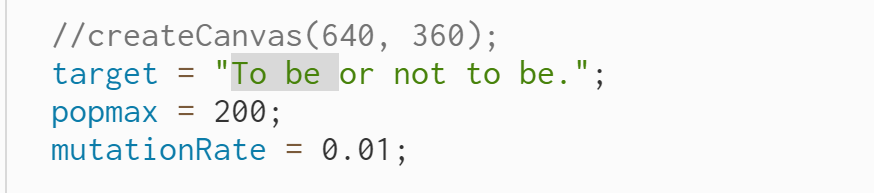

**Cross over**

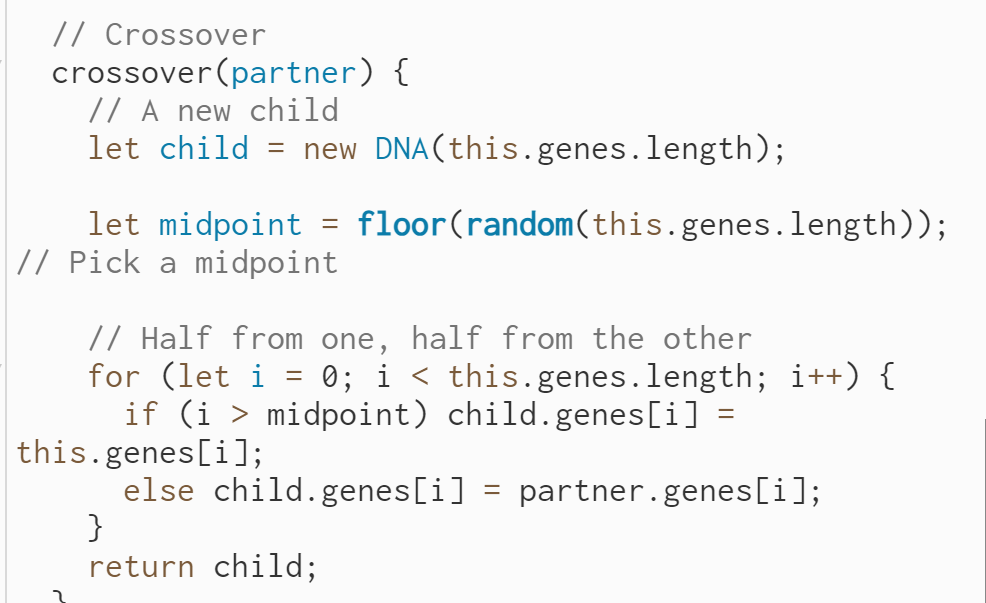

**Método de selección de padres**

En la línea se utiliza natural selection que es definido en Population.js pero se puede cambiar por otro método que incluamos a Population

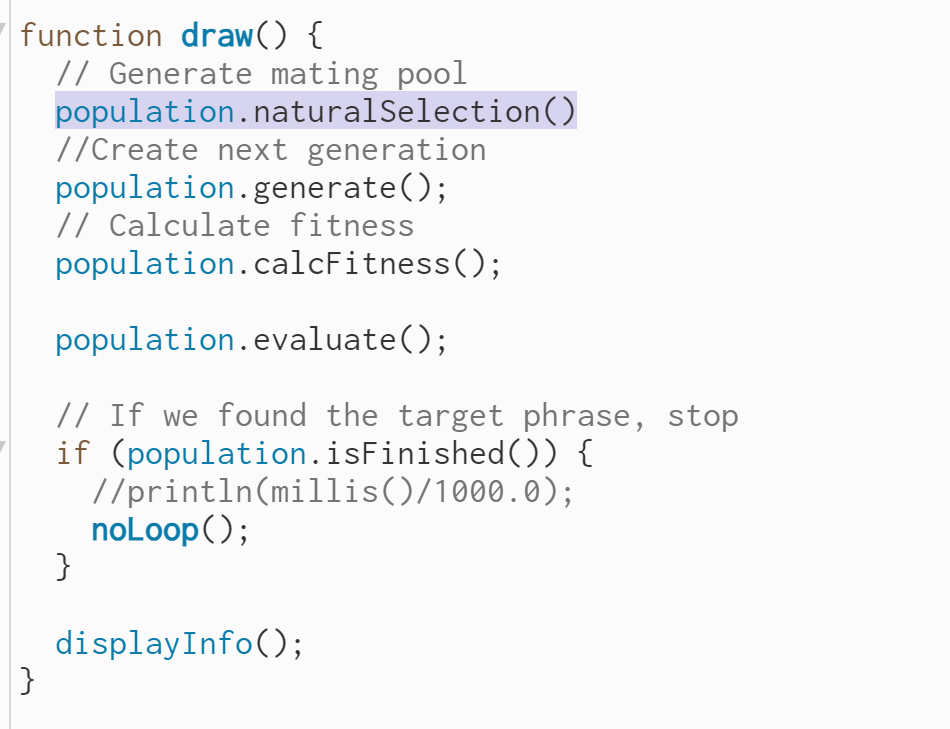

**Función de aptitud**

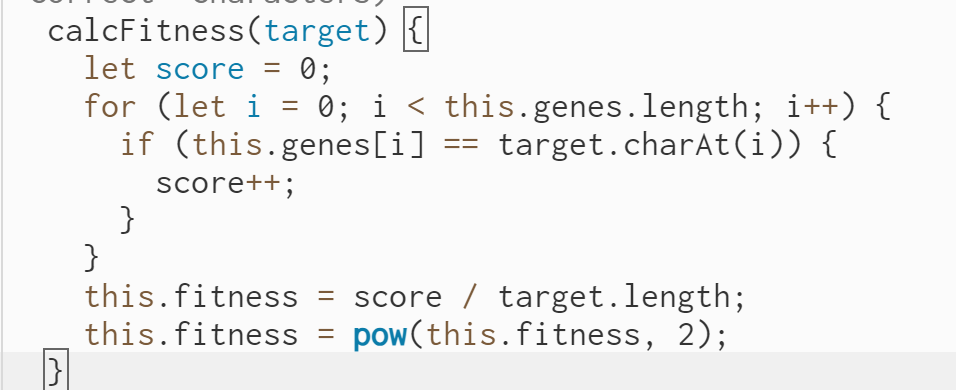

**Genotipo**

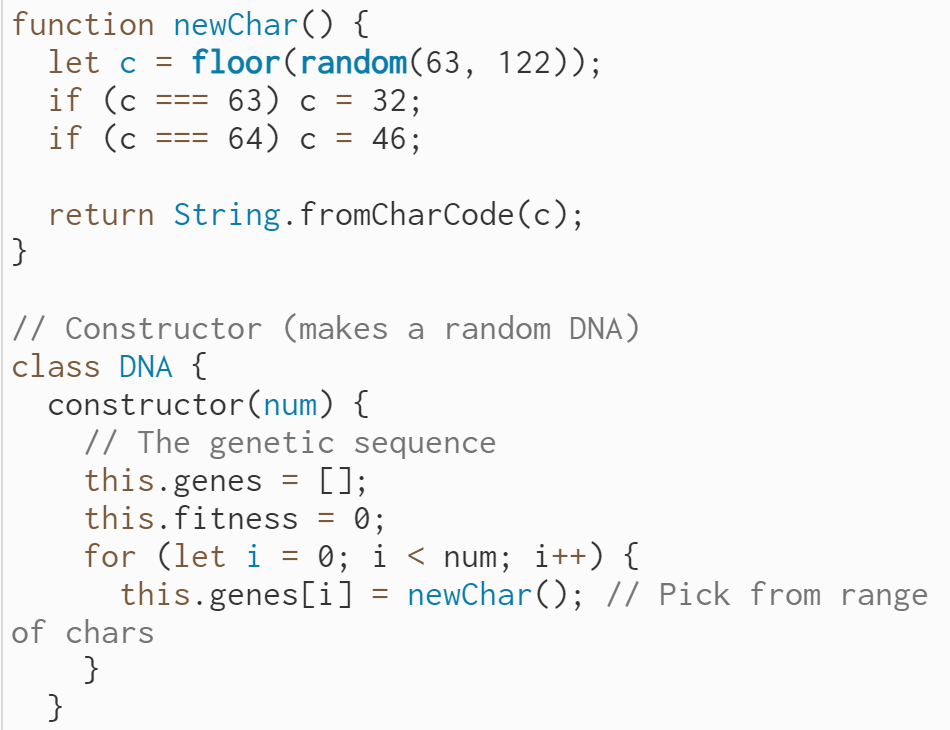